In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import random
import datetime
import glob
from os.path import isfile, join
from sklearn_pandas import DataFrameMapper
import sklearn.preprocessing, sklearn.decomposition, sklearn.pipeline, sklearn.metrics, sklearn.svm, sklearn.tree
import time
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split
import pickle
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
%matplotlib inline

# Load in data

Load in data and store in one pandas DataFrame

In [ ]:
GNSS_data = '/home/kibrom/kwork/sw-GNSS/classifications/data/mcm_GNSS_data_2015.csv'
Solar_data = '/home/kibrom/kwork/sw-GNSS/classifications/data/mcm_Solar_data_2015.csv'
Magnetometer_data = '/home/kibrom/kwork/sw-GNSS/classifications/data/mcm_Magnetometer_data_Carimsa_2015.csv'

#readfiles
gnss = pd.read_csv(GNSS_data)
solar = pd.read_csv(Solar_data)
magneto = pd.read_csv(Magnetometer_data)

In [ ]:
#date time conversions

In [ ]:
gnss['time'] = pd.to_datetime(gnss['datetime'])
solar['time'] = pd.to_datetime(solar['Datetime'])
magneto['time'] = pd.to_datetime(magneto['DateTime'])

-------

In [ ]:
#setting time column as an index for all data frames
for dfs in (gnss, solar, magneto):
    dfs.set_index(['time'], inplace=True)
    dfs.dropna(axis=0)

In [ ]:
#merging the data sets into one data frame
merged_df = pd.merge(pd.merge(gnss,solar, how='outer', on='time', validate='many_to_one'), 
                     magneto,how='outer', on='time', validate='many_to_one')
merged_df.dropna(axis=0, inplace=True);


***

***

In [ ]:
#Labels
feature_tobe_predicted = merged_df['sigmaPhi projected to vertical at prediction time(1h) [radians]']
threshold = 0.1
#binarize (for supervised learning)
def binary_class(feature, threshold):
    if feature <= threshold:
        return 0.0
    else:
        return 1.0
    
#binarize (for supervised learning)
def one_class(feature, threshold):
    if feature <= threshold:
        return 1.0
    else:
        return -1.0
#add binary and one class columns
binarized_feature_tobe_predicted = feature_tobe_predicted.apply(lambda x: binary_class(x, threshold))
oneclass_feature_tobe_predicted = feature_tobe_predicted.apply(lambda x: one_class(x, threshold))
merged_df['sigmaPhi projected to vertical at prediction time(1h) [binarized]'] = binarized_feature_tobe_predicted
merged_df['sigmaPhi projected to vertical at prediction time(1h) [one class]'] = oneclass_feature_tobe_predicted 
#
#lets pickle this data frame for later
merged_df.to_pickle("merged_df_pickled.pkl")

In [2]:
#One can start here once the data frame is pickled.

merged_df = pd.read_pickle("merged_df_pickled.pkl")

***

In [3]:
#lets take sample data 
sample_df = merged_df.sample(100000, random_state = 42)
sample_df.dropna(inplace=True)
sample_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,100000.0,1.125431e+04,1.282596e+03,4318.000000,1.047100e+04,1.160600e+04,1.223200e+04,1.295000e+04
doy,100000.0,1.291257e+02,7.132108e+01,1.000000,7.200000e+01,1.290000e+02,1.860000e+02,2.640000e+02
ut,100000.0,4.270701e+04,2.509210e+04,60.000000,2.082000e+04,4.212000e+04,6.456000e+04,8.634000e+04
azimuth [deg],100000.0,1.809513e+02,4.274063e+01,70.000000,1.500000e+02,1.780000e+02,2.095000e+02,2.860000e+02
elevation [deg],100000.0,4.715454e+01,6.626967e+00,31.000000,4.250000e+01,4.650000e+01,5.050000e+01,7.000000e+01
geographic latitude [deg],100000.0,5.664954e+01,4.540391e-11,56.649535,5.664954e+01,5.664954e+01,5.664954e+01,5.664954e+01
geographic longitude [deg],100000.0,-1.112203e+02,1.793277e-10,-111.220272,-1.112203e+02,-1.112203e+02,-1.112203e+02,-1.112203e+02
TEC at current time [TECU],100000.0,3.664530e+01,9.767593e+00,18.289000,2.892600e+01,3.532275e+01,4.299012e+01,8.856800e+01
dTEC 0min-15s to 0min-0s [TECU],100000.0,-3.354350e-04,4.772386e-02,-1.940500,-1.200000e-02,5.000000e-04,1.300000e-02,2.370500e+00
SI [dimensionless],100000.0,1.383704e-02,4.461909e-03,0.005000,1.100000e-02,1.400000e-02,1.600000e-02,2.300000e-01


# Select features of interest and prepare for ML algorithms

In [4]:
#features of interest 
feature_labels = ['By - 0min [nT]', 'By - 15min [nT]', 'By - 30min [nT]', 
                  'Bz - 0min [nT]', 'Bz - 15min [nT]','Bz - 30min [nT]', 
                  'Vsw - 0min [km/s]', 'Vsw - 15min [km/s]', 'Vsw - 30min [km/s]', 
                  'Psw - 0min [nPa]', 'Psw - 15min [nPa]', 'Psw - 30min [nPa]', 
                  'AE - 0min [nT]', 'AE - 15min [nT]', 'AE - 30min [nT]',
                  'SymH - 0min [nT]', 'SymH - 15min [nT]', 'SymH - 30min [nT]', 
                  'Borovsky CF - 0min [nT km/s]', 'Borovsky CF - 15min [nT km/s]', 'Borovsky CF - 30min [nT km/s]', 
                  'Newell CF - 0min [m/s^(4/3) T^(2/3)]', 'Newell CF - 15min [m/s^(4/3) T^(2/3)]', 'Newell CF - 30min [m/s^(4/3) T^(2/3)]', 
                  'Kp [dimensionless]', 'F107 [sfu=10^-22 W/m^2/hz]', 
                  'Proton 10MeV', 'Proton 30MeV', 'Proton 60MeV', 
                  'GOES X-ray Wm^-2', 'TEC at current time [TECU]', 'dTEC 0min-15s to 0min-0s [TECU]', 
                  'SI [dimensionless]', 'spectral slope [dimensionless]', 'S4 projected to vertical [dimensionless]',
                  'sigmaPhi projected to vertical [radians]', 'X-component','Y-component','Z-component']

#new DataFrame that only now includes the features of interest listed above
features_interest = sample_df[feature_labels]
#


In [5]:
X = features_interest
y_binary = sample_df['sigmaPhi projected to vertical at prediction time(1h) [binarized]']
y_oneclass = sample_df['sigmaPhi projected to vertical at prediction time(1h) [one class]']

In [6]:
X2 = merged_df[feature_labels]
X2['label'] = merged_df['sigmaPhi projected to vertical at prediction time(1h) [binarized]']

/home/kibrom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


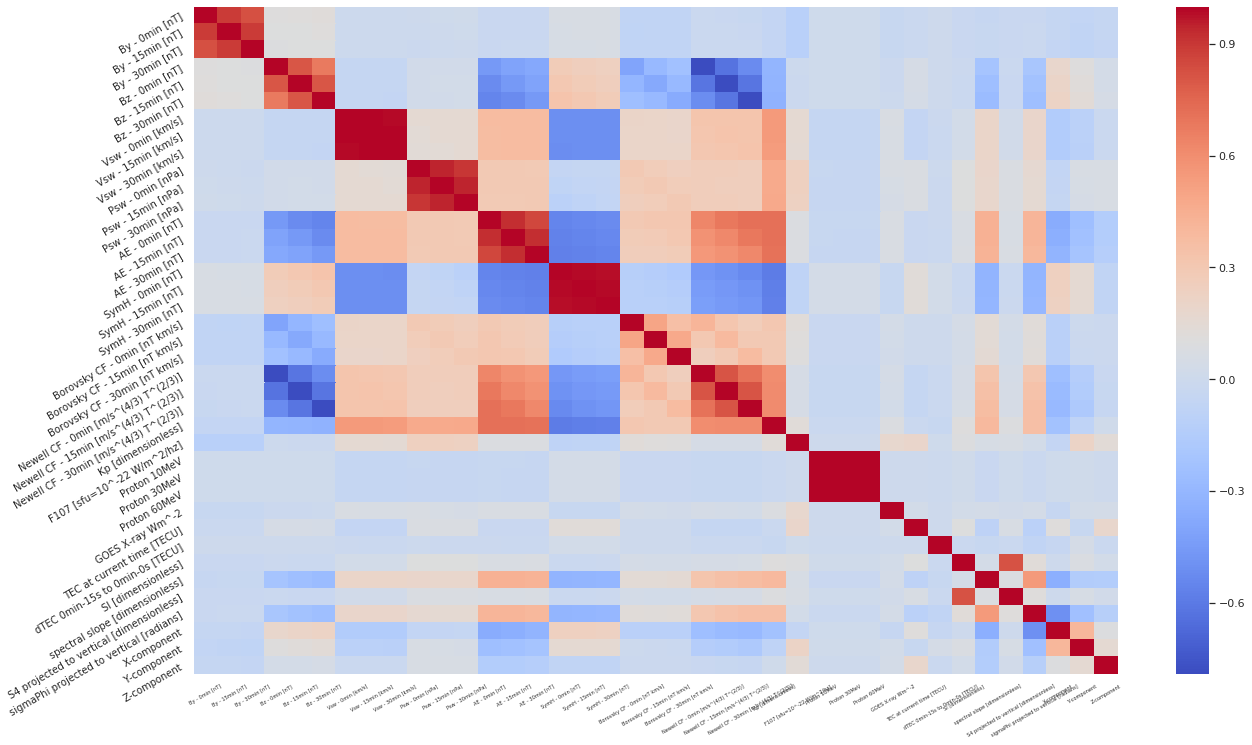

In [7]:
Scint_features=list(X2.columns[0:39]) # select the 'worst' features

sns.set(rc={'figure.figsize':(20.7,12.27)})
s=sns.heatmap(X2[Scint_features].corr(),cmap='coolwarm',) 
s.set_yticklabels(s.get_yticklabels(),rotation=30,fontsize=10)
s.set_xticklabels(s.get_xticklabels(),rotation=30,fontsize=5)
plt.show()


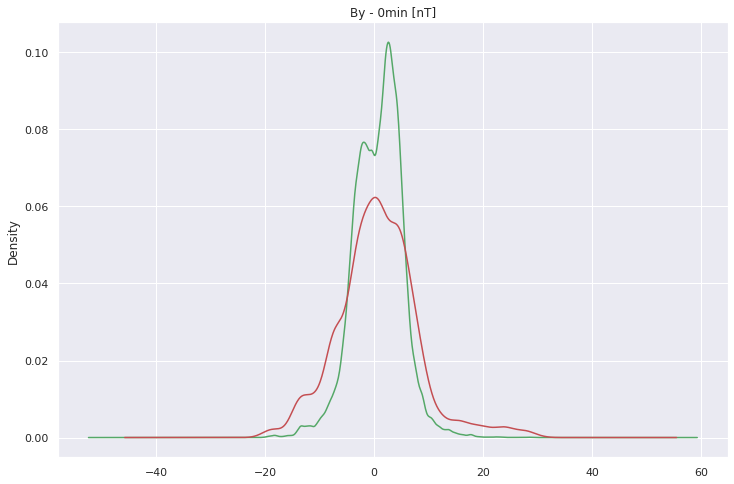

KeyboardInterrupt: 

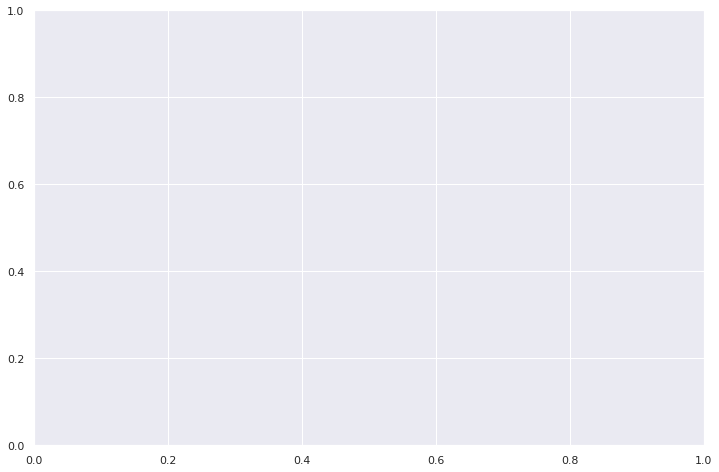

In [8]:
#Distribution of features when there is Scntillation (Red), there is No scntillation (Green)
scint = X2[X2.label == 1]
Noscint = X2[X2.label == 0]

for i in X2.columns:
        Noscint[i].plot(kind='kde', figsize = (12,8), title= i, color='g')
        scint[i].plot(kind='kde', figsize = (12,8), title= i, color='r')
        plt.show()

#Any outliers, gaps, non-stationarity?
- Remove outliers, remove or fill gaps
- Remove trends and seasonality 

# Do we have stationary input features?

Lets do Augmented Dickey-Fuller (adfuller) unit root test to check the stationarity of our input features
#How does it work?
#adfuller is a statistical way of testing if a time series is stationary or not, where the null hypothesis is that the time series is nonstationary

Adfuller returns p-value among other parameters where a small p-value (<0.05) indicates a stationarity of the given time series. p-values larger than 0.05 indicate non-stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller
for feature in X.columns:
    stationarity = adfuller(X[feature]) #stationarity[1] will be the p-value
    if stationarity[1] <= 0.05:
        print('P-value = {one}: Feature "{two}" is Stationary'.format(one=stationarity[1],two=feature))
    else:
        print('P-value = {one}: Feature "{two}" is Non-stationary'.format(one=stationarity[1],two=feature))
    

In [12]:
#Detrending by differencing
X_trended = X.copy()
for each_feature in X_trended.columns:
    X_trended[each_feature] = X_trended[each_feature] - X_trended[each_feature].shift(1)
X_trended.dropna(inplace=True)

In [13]:
X1 = X.copy()
X1.reset_index(inplace=True)

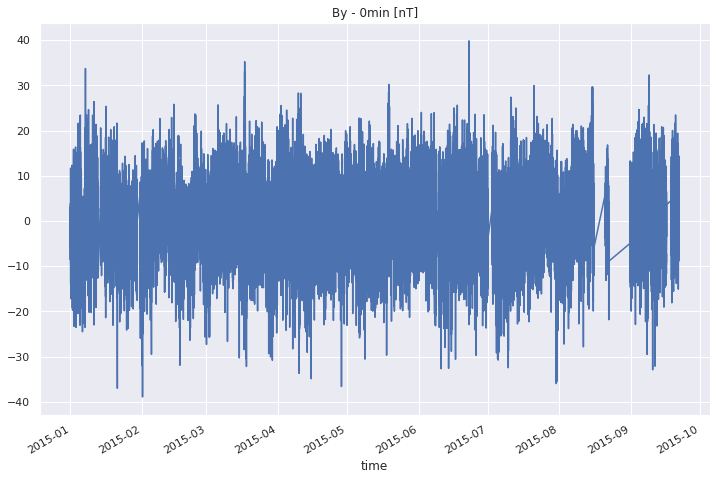

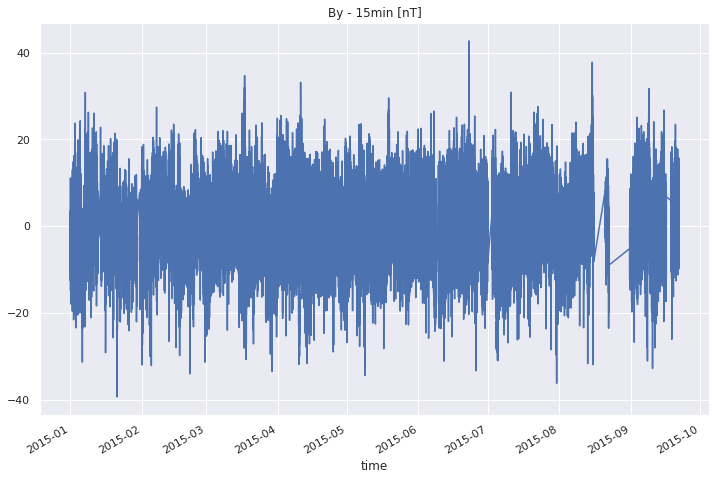

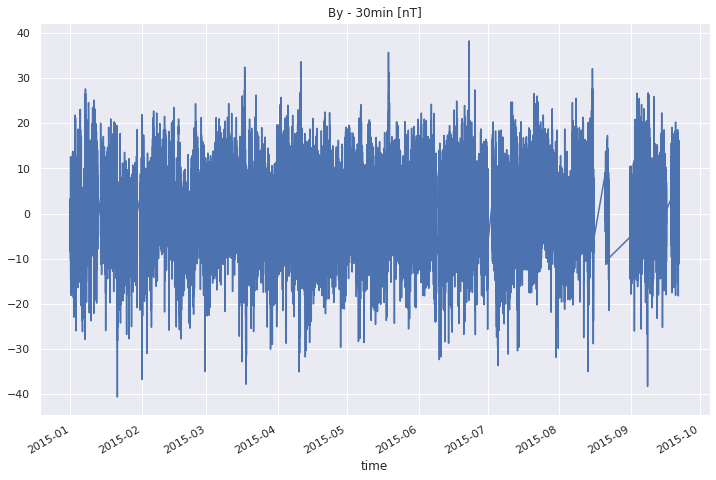

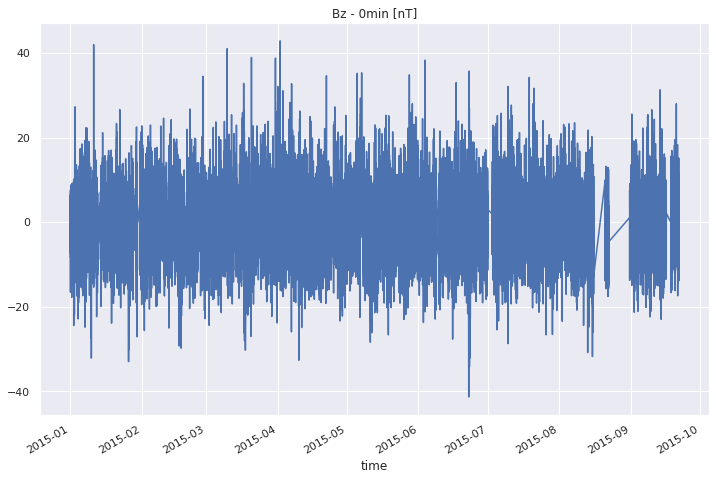

KeyboardInterrupt: 

In [14]:
#plot out detrended features
for i in X_trended.columns:
        X_trended[i].plot(figsize = (12,8), title= i)
        plt.show()

In [15]:
#lets drop the first row of y as the corresposding row in X_trended column is droped as NaN.
y_oneclass_trended = y_oneclass.drop(y_oneclass.index[0])

In [16]:
y_oneclass.shape

(100000,)

In [ ]:

for i in X.columns:
        fig, ax = plt.subplots()
        ax.hist(X[i], bins  = 100)
        plt.title(i)
        plt.show()


In [17]:
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler_X = RobustScaler()
scaler_X = scaler_X.fit(X)

X_scaled = scaler_X.transform(X)

In [ ]:
for i in range(len(X_scaled[0])):
    try:
        fig, ax = plt.subplots()
        ax.hist(X_scaled[:,i], bins  = 100)
    except:
        print(i)

## Scaling input features

 Important to scale features as they all have quite different distrubitions. We scale both linearly and with a log function/ Log1p takes the fact that some data include 0

In [18]:
X.shape

(100000, 39)

In [19]:
#splitting the testing and training data - (80% train, 20%test) # for supervised learning
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, train_size=0.8, random_state=10)

/home/kibrom/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [20]:
list(X_train.columns)

['By - 0min [nT]',
 'By - 15min [nT]',
 'By - 30min [nT]',
 'Bz - 0min [nT]',
 'Bz - 15min [nT]',
 'Bz - 30min [nT]',
 'Vsw - 0min [km/s]',
 'Vsw - 15min [km/s]',
 'Vsw - 30min [km/s]',
 'Psw - 0min [nPa]',
 'Psw - 15min [nPa]',
 'Psw - 30min [nPa]',
 'AE - 0min [nT]',
 'AE - 15min [nT]',
 'AE - 30min [nT]',
 'SymH - 0min [nT]',
 'SymH - 15min [nT]',
 'SymH - 30min [nT]',
 'Borovsky CF - 0min [nT km/s]',
 'Borovsky CF - 15min [nT km/s]',
 'Borovsky CF - 30min [nT km/s]',
 'Newell CF - 0min [m/s^(4/3) T^(2/3)]',
 'Newell CF - 15min [m/s^(4/3) T^(2/3)]',
 'Newell CF - 30min [m/s^(4/3) T^(2/3)]',
 'Kp [dimensionless]',
 'F107 [sfu=10^-22 W/m^2/hz]',
 'Proton 10MeV',
 'Proton 30MeV',
 'Proton 60MeV',
 'GOES X-ray Wm^-2',
 'TEC at current time [TECU]',
 'dTEC 0min-15s to 0min-0s [TECU]',
 'SI [dimensionless]',
 'spectral slope [dimensionless]',
 'S4 projected to vertical [dimensionless]',
 'sigmaPhi projected to vertical [radians]',
 'X-component',
 'Y-component',
 'Z-component']

In [21]:
#X_train.drop(['sigmaPhi projected to vertical [radians]'], axis=1, inplace=True)

In [22]:
print(y_test.shape)

(20000,)


In [23]:
#Scaling data (usinf robust scaler from sckitlearn)
scaler_X = sklearn.preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train)

X_train_scaled = scaler_X.transform(X_train)
X_test_scaled = scaler_X.transform(X_test)



In [24]:
X_train_scaled.shape[1]

39

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=15)# adjust yourself
pca.fit(X_train_scaled)
X_train = pca.transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

In [26]:
#Scaling data (usinf robust scaler from sckitlearn)
scaler_X = sklearn.preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train)

X_scaled = scaler_X.transform(X_train)
pca = PCA(n_components=X_scaled.shape[1])# adjust yourself
pca_vect = pca.fit_transform(X_scaled)

In [27]:
X_scaled.shape[1]

15

In [28]:
pca.explained_variance_ratio_

array([9.99997794e-01, 2.20556621e-06, 3.64210350e-11, 2.55316142e-11,
       8.17270029e-12, 7.39323337e-12, 6.47886703e-12, 4.30770655e-12,
       4.16544575e-12, 3.94327324e-12, 3.59075941e-12, 3.17056168e-12,
       3.15356283e-12, 3.11263575e-12, 2.11160242e-12])

Text(0, 0.5, 'cumulative explained variance ratio')

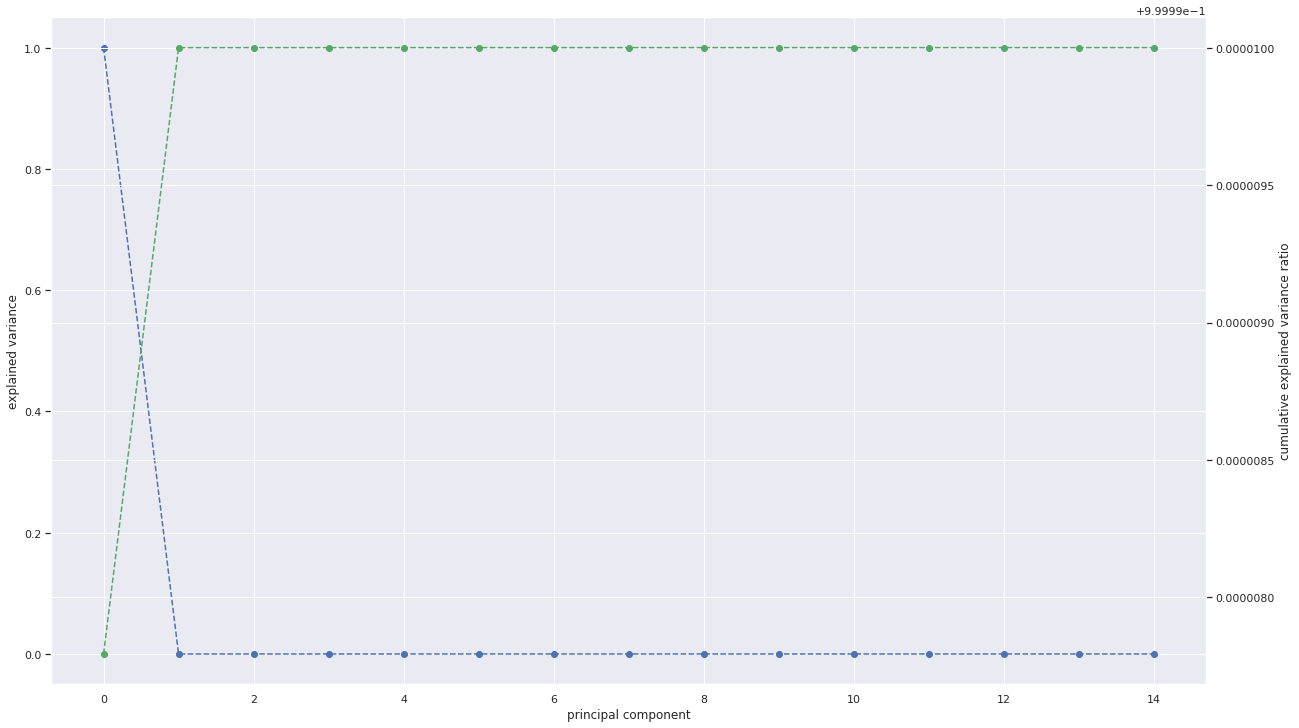

In [29]:


fig, aa = plt.subplots()
plt.plot(pca.explained_variance_ratio_, marker = 'o', ls = '--')
plt.xlabel('principal component')
plt.ylabel('explained variance')
#plt.xlim(0, len(feature_labels))
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(pca.explained_variance_ratio_.cumsum(), marker = 'o', ls = '--', color = 'g')
ax2.set_ylabel('cumulative explained variance ratio')

In [ ]:
for i in range(len(X_train[0])):
    fig, ax = plt.subplots()
    ax.hist(X_train[:,i], bins = 100)
    

# SVM Classification like in McGranaghan et al. 2018,
Using same hyperparameters. Difference is no ovation model as feature, but features now include GOES X-ray and proton fluxs

In [30]:
#create a SVM classification model
from sklearn import svm
clf_scn = round(100*(len(np.where(y_train== 1)[0])/len(np.where(y_train == 0)[0])),2)
print('% of classified scintillation events in sample ', clf_scn)
start = time.time()

clf = svm.SVC(kernel='rbf',C=0.1,gamma=0.01,class_weight={1:100/clf_scn})#,probability=True)
clf.fit(X_train,y_train)

end = time.time()
print('time taken for SVC ', end - start)



% of classified scintillation events in sample  1.95
time taken for SVC  216.01882338523865


In [31]:
clf.score(X_test, y_test)  

0.8959

In [32]:
#use SVC to predict training data
pred = clf.predict(X_test)

In [33]:
confusion_matrix(y_test, pred,[1,0])

array([[  314,    43],
       [ 2039, 17604]])

[17604  2039]
precision 99.7563325211084
recall 89.61971185664103


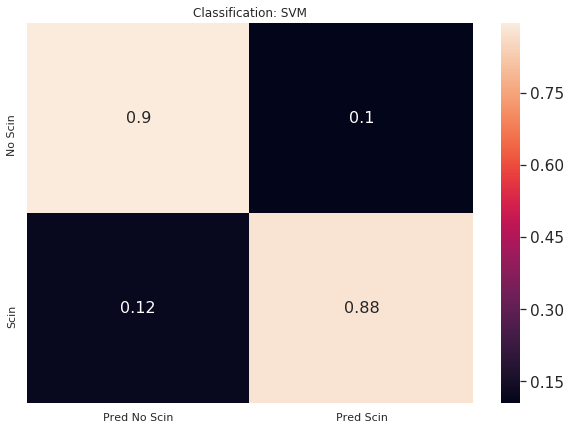

In [34]:
from sklearn.metrics import confusion_matrix
test_arr = confusion_matrix(y_test, pred)
print(test_arr[0])
#precision and recall
tn, fp, fn, tp = confusion_matrix(y_test, pred,[1,0]).ravel()
print('precision', (tp/(tp+fp))*100)
print('recall', (tp/(tp+fn))*100)
    #plot title only accepts strings
precision =  round((tp/(tp+fp))*100,2)
recall = round((tp/(tp+fn))*100,2)
F1 = round(2*((precision*recall)/(precision+recall)),2)
TSS= (round((tp/(tp+fn)) - (fp/(fp+tn)),2))/100
    #
test_arr_n = test_arr.astype('float') / test_arr.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(test_arr_n, ['No Scin','Scin'],
                  ['Pred No Scin', 'Pred Scin'])
plt.figure(figsize = (10,7))
plt.title('Classification: SVM' )
sns.set(font_scale=1.4)#for label size

sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
#plt.savefig('confusion_matrix_normalized_AllStations.png')


In [35]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()

In [36]:
print('precision', (tp/(tp+fp))*100)
print('recall', (tp/(tp+fn))*100)
print("f1: ", metrics.f1_score(y_test, pred))  
print("area under curve (auc): ", metrics.roc_auc_score(y_test, pred))  

precision 13.344666383340417
recall 87.95518207282913
f1:  0.23173431734317343
area under curve (auc):  0.8878744696473508


In [37]:
#function to find the total skill score of prediction
def tss(TP, FP, FN, TN):
    return ((TP)/ (TP + FN)) - (FP)/(FP + TN)


In [38]:
print('The TSS is ',tss(tp, fp, fn, tn))

The TSS is  0.7757489392947017


# One class SVM
Instead of treating the problem as a binary classification, lets assume the scinitllation events as an anomaly in the state of the ionosphere.

In [ ]:
X.shape

In [39]:
#splitting the testing and training data - (80% train, 20%test) # for unsupervised learning
X_train, X_test, y_train, y_test = train_test_split(X, y_oneclass, train_size=0.8, random_state=10)

/home/kibrom/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [40]:
#Scaling data (usinf robust scaler from sckitlearn)
scaler_X = sklearn.preprocessing.RobustScaler()
scaler_X = scaler_X.fit(X_train)

X_train_scaled = scaler_X.transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

pca = PCA(n_components=25)
pca.fit(X_train_scaled)
X_train = pca.transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

In [ ]:
X_train

In [41]:
scint = merged_df[merged_df['sigmaPhi projected to vertical at prediction time(1h) [one class]'] == -1].shape[0]
nu = scint/merged_df['sigmaPhi projected to vertical at prediction time(1h) [one class]'].shape[0]
nu

0.019307301160894175

In [42]:

clf_oneClass = svm.OneClassSVM(nu=0.5, kernel='rbf', gamma=0.01)  
clf_oneClass.fit(X_train) 

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.01, kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [43]:
preds = clf_oneClass.predict(X_train)  

print("accuracy: ", metrics.accuracy_score(y_train, preds))  
print("precision: ", metrics.precision_score(y_train, preds))  
print("recall: ", metrics.recall_score(y_train, preds))  
print("f1: ", metrics.f1_score(y_train, preds))  
print("area under curve (auc): ", metrics.roc_auc_score(y_train, preds))  

accuracy:  0.51775
precision:  0.9986500337491563
recall:  0.5090540695525849
f1:  0.6743589310734844
area under curve (auc):  0.7368453058961353


#train
accuracy:  0.9640625
precision:  0.9817859692056694
recall:  0.9815732799816498
f1:  0.981679613073428
area under curve (auc):  0.5228757035140731

In [44]:
preds = clf_oneClass.predict(X_test)  

print("accuracy: ", metrics.accuracy_score(y_test, preds))  
print("precision: ", metrics.precision_score(y_test, preds))  
print("recall: ", metrics.recall_score(y_test, preds))  
print("f1: ", metrics.f1_score(y_test, preds))  
print("area under curve (auc): ", metrics.roc_auc_score(y_test, preds))  

accuracy:  0.5163
precision:  0.9982008995502248
recall:  0.5084253932698671
f1:  0.6737048030221263
area under curve (auc):  0.7290026126013202


#test
accuracy:  0.9652
precision:  0.9831199959202407
recall:  0.9814183169576949
f1:  0.9822684194435952
area under curve (auc):  0.527123724305178

[339  18]
precision 99.82008995502248
recall 50.84253932698671


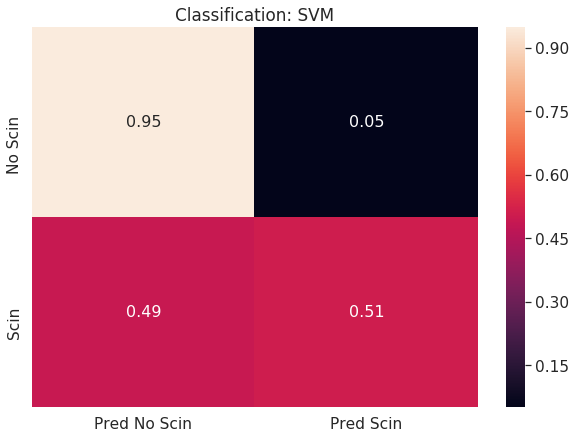

In [46]:
test_arr = confusion_matrix(y_test, preds)
print(test_arr[0])
#precision and recall
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print('precision', (tp/(tp+fp))*100)
print('recall', (tp/(tp+fn))*100)
    #plot title only accepts strings
precision =  round((tp/(tp+fp))*100,2)
recall = round((tp/(tp+fn))*100,2)
F1 = round(2*((precision*recall)/(precision+recall)),2)
TSS= (round((tp/(tp+fn)) - (fp/(fp+tn)),2))/100
    #
test_arr_n = test_arr.astype('float') / test_arr.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(test_arr_n, ['No Scin','Scin'],
                  ['Pred No Scin', 'Pred Scin'])
plt.figure(figsize = (10,7))
plt.title('Classification: SVM' )
sns.set(font_scale=1.4)#for label size

sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})# font size
#plt.savefig('confusion_matrix_normalized_AllStations.png')


In [47]:
tss(tp, fp, fn, tn)

0.45800522520264025

In [48]:
confusion_matrix(y_test, preds)

array([[ 339,   18],
       [9656, 9987]])

In [50]:
#Grid search for one class svm hyperparameters 